# Setup and Data Loading

This section imports necessary libraries for data manipulation, network analysis, and visualization, and loads the pass data for analysis.

In [1]:
# Import libraries for data manipulation, network analysis, and visualization
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch
import pandas as pd

df= pd.read_csv(r"C:\Users\santo\Downloads\match_events.csv")

null_values = df.isnull().sum()

# Display the count of null values
print("Null values in each column:")
print(null_values)

df.fillna(0, inplace=True)

print(df)
df = df[df['team_id']=='Manchester City']
df.rename(columns={'type_display_name': 'type'}, inplace=True)
df.rename(columns={'outcome_type_display_name': 'outcome'}, inplace=True)
df.rename(columns={'team_id': 'team'}, inplace=True)
df.rename(columns={'player_name': 'player'}, inplace=True)
df.rename(columns={'Position': 'position'}, inplace=True)
df.rename(columns={'period_display_name': 'period'}, inplace=True)
df['recipient'] = df['player'].shift(-1)
df.head()

print(df.columns)

#check for index of first sub
sub = df.loc[df["type"] == "SubstitutionOff"].loc[df["team"] == "Manchester City"].iloc[0]["index"]
#make df with successfull passes by England until the first substitution
mask_city = (df.type== 'Pass') & (df.team == "Manchester City") & (df.index < sub) & (df.outcome== 'Successful')
#taking necessary columns
df_pass = df.loc[mask_city, ['x', 'y', 'end_x', 'end_y', "player", "recipient"]]
df_pass["player"] = df_pass["player"].apply(lambda x: str(x).split()[-1])
df_pass["recipient"] = df_pass["recipient"].apply(lambda x: str(x).split()[-1])

scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player"].unique()):
    passx = df_pass.loc[df_pass["player"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["recipient"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["recipient"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player"], x["recipient"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>0]




Null values in each column:
index                          0
event_id                       0
minute                         0
second                         0
team_id                        0
player_id                      0
x                              0
y                              0
end_x                        471
end_y                        471
type_display_name              0
outcome_type_display_name      0
period_display_name            0
player_name                    0
Position                       0
dtype: int64
      index  event_id  minute  second          team_id  player_id     x     y  \
0         1         3       0       0  Manchester City      77464  49.9  50.0   
1         2         4       0       6  Manchester City     121774  27.5  51.6   
2         3         5       0      13  Manchester City     101374  47.8  40.6   
3         4         6       0      15  Manchester City     297390  45.5  78.6   
4         5         7       0      17  Manchester City     

#Pass Network Visualization

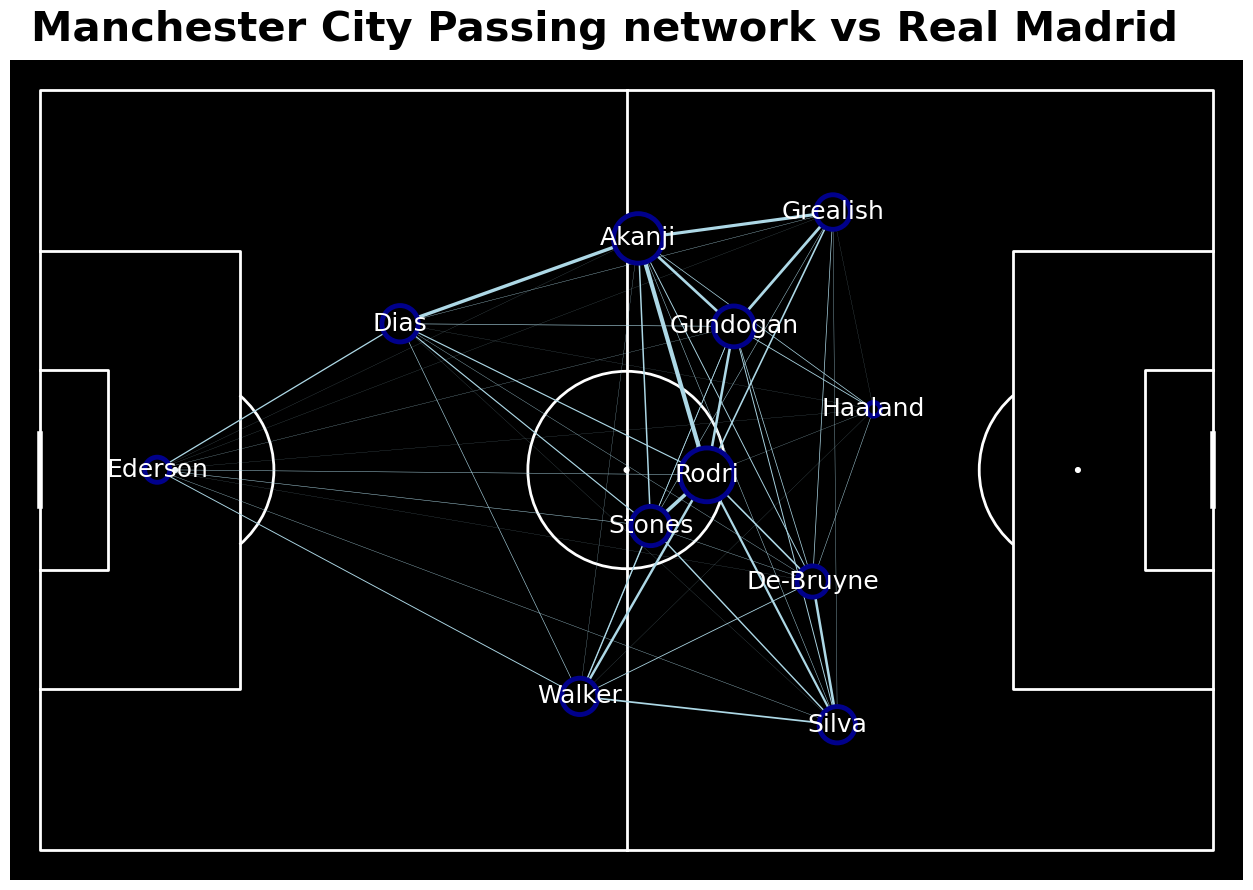

In [2]:
# Load pass data and visualize the pitch to understand the data's context

from mplsoccer import Pitch
import matplotlib.pyplot as plt



fig, ax = plt.subplots(figsize=(18, 10))
# Create the Pitch object with adjusted scale and colors
pitch = Pitch(pitch_type='opta', pitch_color='black', line_color='white', pitch_length=120, pitch_width=80)

pitch.draw(ax=ax)
#existing code for scatter and lines
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='black', edgecolors='darkblue', linewidth=3.5, alpha=1, ax=ax, zorder=3)

for i, row in scatter_df.iterrows():
   
    ax.text(row.x + 0, row.y + 0, row.player, color='white', va='center', ha='center', size=18, zorder=4)

for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row['pair_key'].split("_")[1]
    player1_x = scatter_df.loc[scatter_df["player"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["player"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]
    line_width = (num_passes / lines_df['pass_count'].max() * 3)
    pitch.lines(player1_x, player1_y, player2_x, player2_y,
                alpha=1, lw=line_width, zorder=2, color="lightblue", ax=ax)


plt.subplots_adjust(top=0.93)
fig.suptitle("Manchester City Passing network vs Real Madrid", fontsize=30,fontweight='bold')
# Show the plot
plt.show()


fig.savefig(r'C:\Users\santo\OneDrive\Wyscout\PassNetwork_image_name.png')  

# Data Preparation

Prepare the data for visualization, including calculating average locations and summarizing pass counts.

In [3]:
average_locations = scatter_df.groupby('player')[['x', 'y']].mean().reset_index()
print(average_locations)


       player          x          y
0      Akanji  50.996644  80.501342
1   De-Bruyne  65.870270  35.310811
2        Dias  30.682051  69.264103
3     Ederson   9.963889  50.033333
4    Grealish  67.602410  83.973494
5    Gundogan  59.146296  68.911111
6     Haaland  71.060870  57.991304
7       Rodri  56.854286  49.362857
8       Silva  67.970115  16.450575
9      Stones  52.052041  42.621429
10     Walker  46.009333  20.185333


In [6]:
# Calculate average locations for each player
print(lines_df)
lines_df.groupby('pass_count').sum() 


              pair_key  pass_count
0     Akanji_De-Bruyne           8
1          Akanji_Dias          29
2       Akanji_Ederson           1
3      Akanji_Grealish          27
4      Akanji_Gundogan          23
5       Akanji_Haaland           6
6         Akanji_Rodri          36
7         Akanji_Silva           4
8        Akanji_Stones          13
9        Akanji_Walker           2
10      De-Bruyne_Dias           3
11   De-Bruyne_Ederson           1
12  De-Bruyne_Grealish           6
13  De-Bruyne_Gundogan           6
14   De-Bruyne_Haaland           4
15     De-Bruyne_Rodri          14
16     De-Bruyne_Silva          22
17    De-Bruyne_Stones           3
18    De-Bruyne_Walker           7
19        Dias_Ederson          11
20       Dias_Grealish           3
21       Dias_Gundogan           5
22        Dias_Haaland           1
23          Dias_Rodri          10
24          Dias_Silva           1
25         Dias_Stones          10
26         Dias_Walker           5
27    Ederson_Greali

,pair_key
pass_count,
1,Akanji_EdersonDe-Bruyne_EdersonDias_HaalandDia...
2,Akanji_WalkerEderson_GundoganHaaland_Rodri
3,De-Bruyne_DiasDe-Bruyne_StonesDias_GrealishEde...
4,Akanji_SilvaDe-Bruyne_HaalandEderson_RodriEder...
5,Dias_GundoganDias_Walker
6,Akanji_HaalandDe-Bruyne_GrealishDe-Bruyne_Gund...
7,De-Bruyne_WalkerGundogan_HaalandGundogan_Stones
8,Akanji_De-BruyneEderson_WalkerGundogan_Silva
10,Dias_RodriDias_Stones


In [4]:
# Summarize pass counts
df_pass

,x,y,end_x,end_y,player,recipient,pair_key
0,49.9,50.0,18.9,52.7,Gundogan,Ederson,Ederson_Gundogan
1,27.5,51.6,39.3,20.8,Ederson,Stones,Ederson_Stones
2,47.8,40.6,45.5,78.0,Stones,Akanji,Akanji_Stones
3,45.5,78.6,58.2,81.5,Akanji,Gundogan,Akanji_Gundogan
4,56.4,85.2,35.4,96.6,Gundogan,Akanji,Akanji_Gundogan
...,...,...,...,...,...,...,...
1322,42.1,89.6,42.0,73.7,Akanji,Gundogan,Akanji_Gundogan
1323,42.3,73.2,34.0,56.1,Gundogan,Stones,Gundogan_Stones
1324,36.2,62.4,44.5,66.5,Stones,Rodri,Rodri_Stones
1325,41.6,64.7,32.3,29.9,Rodri,Walker,Rodri_Walker


#Centralities Visualizations



Eigenvector Centrality Table:
       player  pass_count  eigenvector_centrality  \
0       Rodri          92                0.350134   
1    Gundogan          53                0.343325   
2   De-Bruyne          31                0.343325   
3      Akanji          78                0.317456   
4      Stones          49                0.310202   
5     Haaland           6                0.284788   
6    Grealish          38                0.284057   
7      Walker          42                0.284057   
8        Dias          42                0.277881   
9       Silva          42                0.251624   
10    Ederson          20                0.248285   

    centralisation_index_eigenvector  
0                           0.000000  
1                           0.000207  
2                           0.000207  
3                           0.000992  
4                           0.001212  
5                           0.001983  
6                           0.002005  
7                    

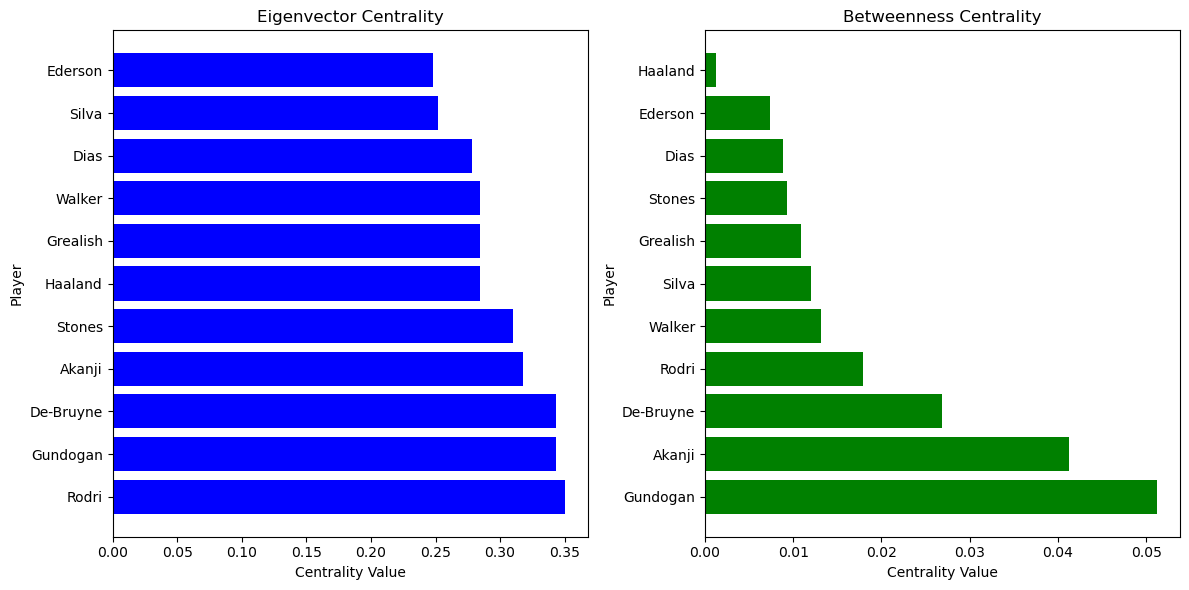

In [6]:
# Create and visualize the pass network
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_pandas_edgelist(df_pass, 'player', 'recipient', create_using=nx.DiGraph())

# Eigenvector centrality for each player
eigenvector_centrality = nx.eigenvector_centrality_numpy(G)

# Betweenness centrality for each player
betweenness_centrality = nx.betweenness_centrality(G)

# Convert the centralities to DataFrames
df_eigenvector = pd.DataFrame(list(eigenvector_centrality.items()), columns=['player', 'eigenvector_centrality'])
df_betweenness = pd.DataFrame(list(betweenness_centrality.items()), columns=['player', 'betweenness_centrality'])

# Group by 'player' and count the number of passes for each player
no_passes = df_pass.groupby(['player']).size().reset_index(name='pass_count')

# Merge with the pass count DataFrame
result_df_eigenvector = pd.merge(no_passes, df_eigenvector, on='player', how='left')
result_df_betweenness = pd.merge(no_passes, df_betweenness, on='player', how='left')

# Calculate centralization indices for each player
result_df_eigenvector['centralisation_index_eigenvector'] = (result_df_eigenvector["eigenvector_centrality"].max() - result_df_eigenvector["eigenvector_centrality"]) / (10 * result_df_eigenvector["eigenvector_centrality"].sum())
result_df_betweenness['centralisation_index_betweenness'] = (result_df_betweenness["betweenness_centrality"].max() - result_df_betweenness["betweenness_centrality"]) / (10 * result_df_betweenness["betweenness_centrality"].sum())

# Sort the DataFrames based on centralization indices (from lowest to highest)
result_df_eigenvector.sort_values(by='centralisation_index_eigenvector', ascending=True, inplace=True)
result_df_betweenness.sort_values(by='centralisation_index_betweenness', ascending=True, inplace=True)


result_df_eigenvector.reset_index(drop=True, inplace=True)
result_df_betweenness.reset_index(drop=True, inplace=True)

# Print the resulting DataFrames
print("Eigenvector Centrality Table:")
print(result_df_eigenvector)

print("\nBetweenness Centrality Table:")
print(result_df_betweenness)

# Plotting
plt.figure(figsize=(12, 6))

# Eigenvector Centrality
plt.subplot(1, 2, 1)
plt.barh(result_df_eigenvector['player'], result_df_eigenvector['eigenvector_centrality'], color='blue')
plt.title('Eigenvector Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Player')

# Betweenness Centrality
plt.subplot(1, 2, 2)
plt.barh(result_df_betweenness['player'], result_df_betweenness['betweenness_centrality'], color='green')
plt.title('Betweenness Centrality')
plt.xlabel('Centrality Value')
plt.ylabel('Player')

plt.tight_layout()
plt.show()







In [8]:
no_passes = df_pass.groupby(['player']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max()
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum()
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.1052738336713996
